Loading the important libraris

In [1]:
import pandas as pd
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Embedding, Dropout, Dense, LSTM, GRU, Bidirectional, Conv1D, GlobalMaxPool1D
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import itertools
import json

2024-02-18 21:36:17.151567: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 21:36:17.151667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 21:36:17.294225: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
!pip install --upgrade transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 82.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.37.0
    Uninstalling transformers-4.37.0:
      Successfully uninstalled transformers-4.37.0


In [7]:
# importing important libraries
import torch
import itertools
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [8]:
# seed everythig

SEED_VAL = 42
torch.manual_seed(SEED_VAL)
torch.cuda.manual_seed_all(SEED_VAL)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [9]:
# Hyperparameters

MAX_LENGTH = 100
LR = 2e-5
BATCH_SIZE = 16
EPOCHS = 3

In [15]:
# model and tokenizer

MODEL = 'nlptown/bert-base-multilingual-uncased-sentiment'

In [16]:
# loading the data
df = pd.read_csv('/kaggle/input/balanced-data/balanced_data.csv')
train, test = train_test_split(df, test_size=0.2, stratify=df.label, random_state=SEED_VAL)
test, val = train_test_split(test, test_size=0.5, stratify=test.label, random_state=SEED_VAL)

train_text = list(train.text)
train_labels = list(train.label)

val_text = list(val.text)
val_labels = list(val.label)

test_text = list(test.text)
test_labels = list(test.label)

print('Total: ', len(df))
print('Train: ', len(train))
print('Val: ', len(val))
print('Test: ', len(test))

Total:  44000
Train:  35200
Val:  4400
Test:  4400


In [17]:
# df['text'][1421]
df

,text,label
0,د جنګ د مفهوم او معنا څخه ناخبره معصوم ماشومان...,0
1,تردې وروسته يې خپله دوکتورا د وګړپوهنې په څانګ...,0
2,د افغانستان د کرکټ لوبغاړي اماراتو ته رسېدلي د...,0
3,د بابا تازه انځور ته زړونه ورکړئ ❤,0
4,البيت الابراهيمي,0
...,...,...
43995,ستا مور له عزته سره وغيم فراري دي مور غولي ملي...,1
43996,ستا مفکوره د پنجاسپیتوب مفکوره ده وړه نجلکۍ یې...,1
43997,ددناموس وغیم خوچی نیسی یی مردار ه وایی ولی هسی...,1
43998,ډیر عجب ښه کار وشو داسی خبیث خلک همداسی سزا ور...,1


In [18]:
# Tokenization
# from transformers import DistilBertTokenizerFast , TFDistilBertForSequenceClassification

tokenizer =BertTokenizer.from_pretrained(MODEL)
train_encodings = tokenizer(train_text, truncation=True, padding='max_length', max_length=MAX_LENGTH)
val_encodings = tokenizer(val_text, truncation=True, padding='max_length', max_length=MAX_LENGTH)
test_encodings = tokenizer(test_text, truncation=True, padding='max_length', max_length=MAX_LENGTH)

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

In [20]:
# Torch Dataset

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = MyDataset(train_encodings, train_labels)
val_dataset = MyDataset(val_encodings, val_labels)
test_dataset = MyDataset(test_encodings, test_labels)

In [21]:
!pip install transformers[torch] -U
!pip install accelerate -U


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.26.1
    Uninstalling accelerate-0.26.1:
      Successfully uninstalled accelerate-0.26.1


In [22]:
# Training Arguments


!pip install transformers[torch]

from transformers import TrainingArguments, Trainer

# Rest of your code
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR,
    logging_steps=50,
    save_strategy='no',
    evaluation_strategy='steps',
    logging_strategy='steps',
    report_to='none',
)

# Continue with your Trainer setup and training


In [23]:
# Model and Trainer

model = BertForSequenceClassification.from_pretrained(MODEL)
trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=val_dataset)

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [24]:
# Start Fine-tuning

trainer.train()

Step,Training Loss,Validation Loss
50,0.630300,0.604264
100,0.486600,0.602333
150,0.478000,0.509333
200,0.457400,0.343803
250,0.378000,0.335204
300,0.394700,0.361867
350,0.373700,0.302759
400,0.293800,0.285598
450,0.317900,0.291522
500,0.320500,0.261230


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



TrainOutput(global_step=6600, training_loss=0.20189584750117678, metrics={'train_runtime': 2989.2946, 'train_samples_per_second': 35.326, 'train_steps_per_second': 2.208, 'total_flos': 5426811688320000.0, 'train_loss': 0.20189584750117678, 'epoch': 3.0})

In [13]:
# trainer.evaluate()

In [ ]:
# print(logs.columns)
#

In [13]:
# Loss curves
logs = pd.DataFrame(trainer.state.log_history)
logs.to_csv('history.txt', sep='\t', index=None)


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Assuming logs is your DataFrame containing the training logs
# logs = pd.DataFrame(trainer.state.log_history)

# # Filter out any steps where the loss is not greater than  0
# loss = logs.loc[logs['train_loss'] >  0]

# # Plot the training loss
# plt.figure(figsize=(2.8,  2))
# plt.plot(loss.step, loss['train_loss'], label='Train Loss', lw=1)
# plt.legend(['Train Loss'], loc='upper right')
# plt.xlabel('Steps', fontsize=11)
# plt.ylabel('Loss', fontsize=11)
# plt.title('Pashto-BERT')
# plt.show()


In [25]:
# Testing and prediction
preds_raw, test_labels , _ = trainer.predict(test_dataset)
preds = np.argmax(preds_raw, axis=-1)
print(classification_report(test_labels, preds, digits=4))

              precision    recall  f1-score   support

           0     0.9401    0.9345    0.9373      2200
           1     0.9349    0.9405    0.9377      2200

    accuracy                         0.9375      4400
   macro avg     0.9375    0.9375    0.9375      4400
weighted avg     0.9375    0.9375    0.9375      4400



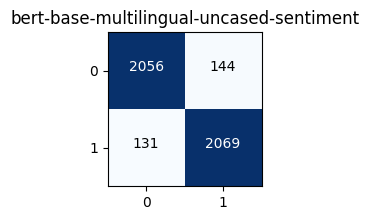

In [26]:
# confusion matrix
cm = confusion_matrix(test_labels, preds)
plt.figure(figsize=(2,2))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('bert-base-multilingual-uncased-sentiment')
tick_marks = np.arange(2)
plt.xticks([0,1])
plt.yticks([0,1])
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.show()

In [27]:
# saving the model
trainer.save_model('model')

In [28]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [36]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# Specify the directory where your fine-tuned model is saved
model_directory = '/kaggle/working/model'

# Load the tokenizer and the model
tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')  # Correct tokenizer for DistilBERT
model = BertForSequenceClassification.from_pretrained(model_directory)  # Correct model for DistilBERT
# Ensure the model is in evaluation mode
model.eval()

# Function to preprocess the text and make predictions
def predict_sentiment(text):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)

    # Move the tensors to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Get the model's predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted class (assuming binary classification)
    predicted_class = torch.argmax(outputs.logits, dim=-1).item()

    return predicted_class

# Example usage
text = "مړه یو کس وی صرف ځان شرموی او یو ستا غوندے جاهل وی چې قوم او ملت شرموی"
predicted_sentiment = predict_sentiment(text)
print(f"Predicted sentiment for '{text}': {predicted_sentiment}")


Predicted sentiment for 'مړه یو کس وی صرف ځان شرموی او یو ستا غوندے جاهل وی چې قوم او ملت شرموی': 1


In [37]:
text2 = "زه دا محصول خوښوم!"
predicted_sentiment2 = predict_sentiment(text2)
print(f"Predicted sentiment for '{text2}': {predicted_sentiment2}")


Predicted sentiment for 'زه دا محصول خوښوم!': 0


In [38]:
text4 = "هههه حرام تل حرام وي کومه وحې را نازله شوه چې زده کړې حلالې شوې داسې ووایه چې د امریکا سوټي په زور خلاصیږي"
predicted_sentiment3 = predict_sentiment(text4)
print(f"Predicted sentiment for '{text4}': {predicted_sentiment3}")


Predicted sentiment for 'هههه حرام تل حرام وي کومه وحې را نازله شوه چې زده کړې حلالې شوې داسې ووایه چې د امریکا سوټي په زور خلاصیږي': 1
